# Reconstrucción 3D a partir de imágenes usando Structure from Motion (SfM)
### Alejandro Vega Saavedra

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Paso 1: Carga de  Imágenes

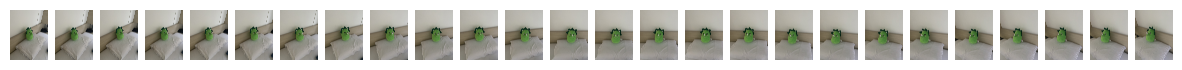

In [2]:
directorio_imagenes = "../imagenes/"

imagenes = []
archivos_imagenes = os.listdir(directorio_imagenes)

for archivo in archivos_imagenes:
    ruta = os.path.join(directorio_imagenes, archivo)
    img = cv2.imread(ruta, cv2.IMREAD_COLOR)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imagenes.append(img)

fig, axs = plt.subplots(1, len(imagenes), figsize=(15, 1))
for ax, img in zip(axs, imagenes):
    ax.imshow(img)
    ax.axis('off')

plt.show()

## Paso 2: Preprocesamiento de Imágenes

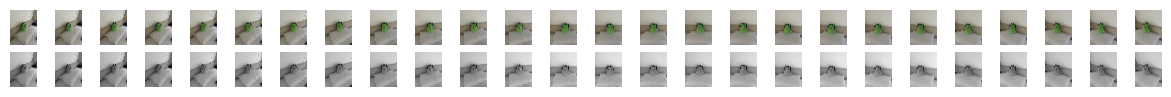

In [3]:
imagenes_bw = []
archivos_imagenes_bw = os.listdir("../imagenes/imagenes bw/")

for i, img in enumerate(imagenes):
    bw_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    imagenes_bw.append(bw_img)

    filename = archivos_imagenes[i + 2]
    cv2.imwrite(os.path.join("../imagenes/imagenes bw/", filename), bw_img)

fig, axs = plt.subplots(2, len(imagenes), figsize=(15, 1))
for i, (img, bw) in enumerate(zip(imagenes, imagenes_bw)):
    axs[0,i].imshow(img)
    axs[0,i].axis('off')
    axs[1,i].imshow(bw, cmap='gray')
    axs[1,i].axis('off')
plt.show()

## Paso 3: Estimación de la Matriz Fundamental y la Matriz Esencial

In [4]:
def visualizar_matriz(matriz):

    plt.figure(figsize=(matriz.shape[1]*3, matriz.shape[0]*3))
    plt.imshow(matriz, cmap='viridis')
    

    for i in range(matriz.shape[0]):
        for j in range(matriz.shape[1]):

            valor = f'{matriz[i,j]:.3f}'

            plt.text(j, i, valor,
                    ha='center', va='center', 
                    color='black',
                    fontsize=14,
                    fontweight='bold')
    
    plt.colorbar()
    
    plt.tight_layout(pad=4.0)
    
    plt.show()

### Matriz intrínseca K

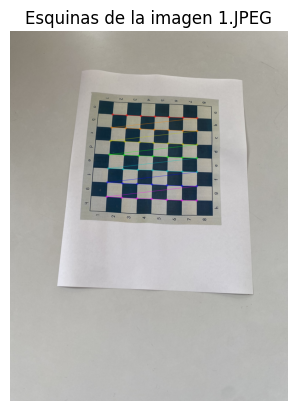

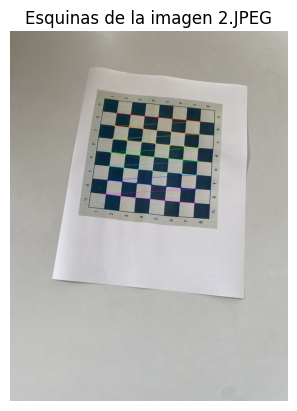

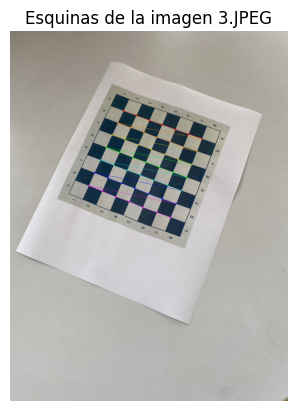

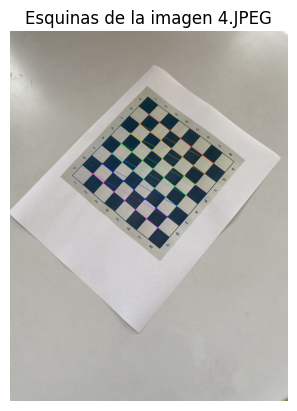

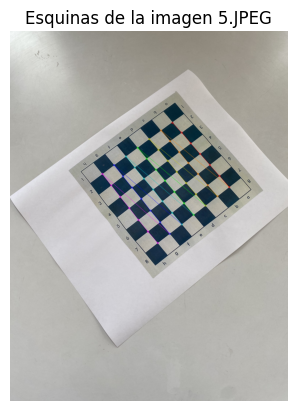

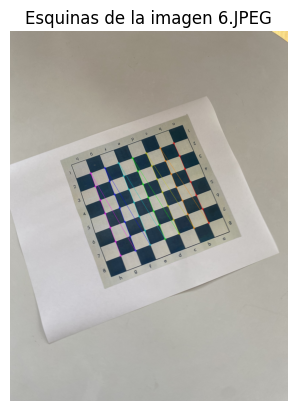

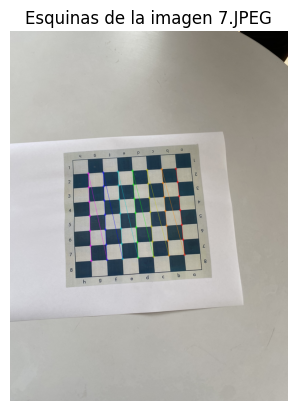

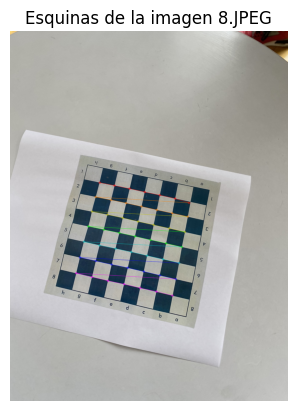

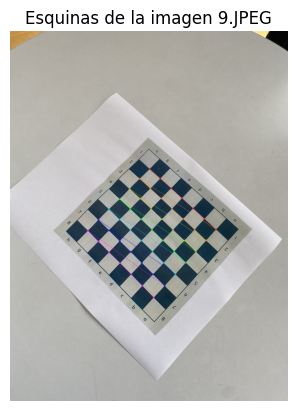

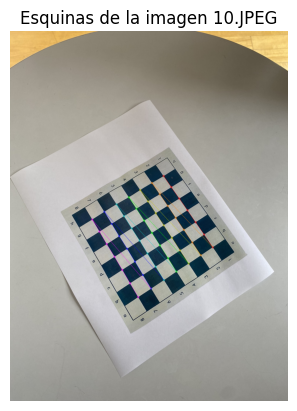

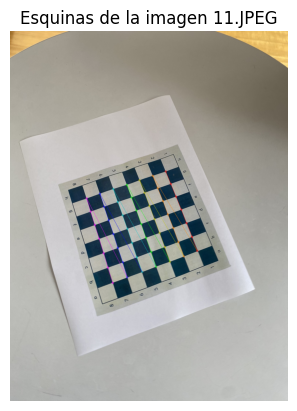

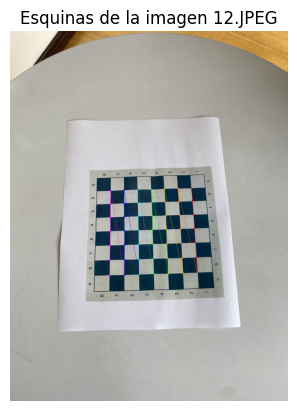

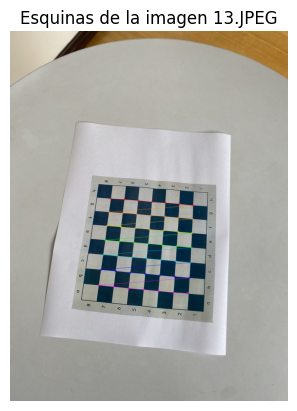

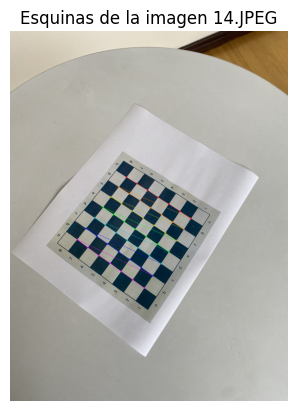

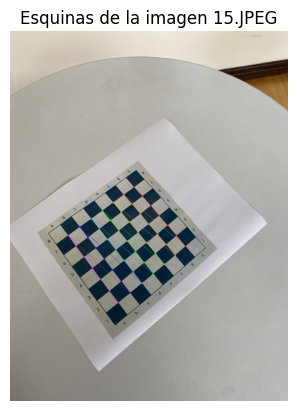

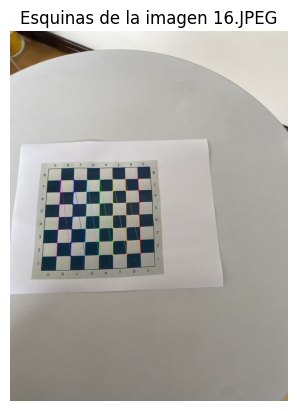

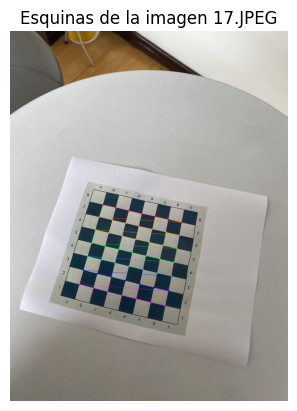

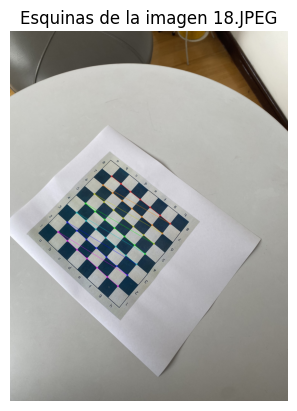

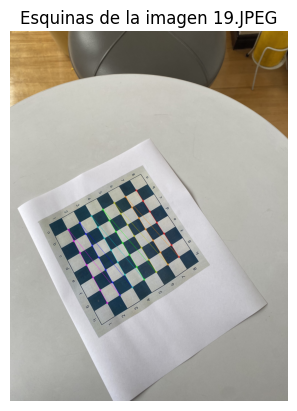

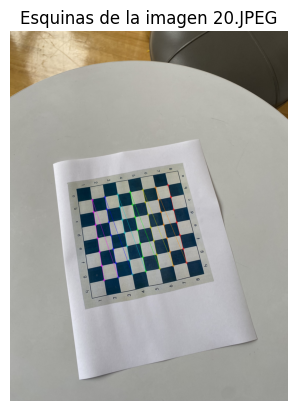

[[3.43689325e+03 0.00000000e+00 7.81719952e+02]
 [0.00000000e+00 3.99260426e+03 9.96314772e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


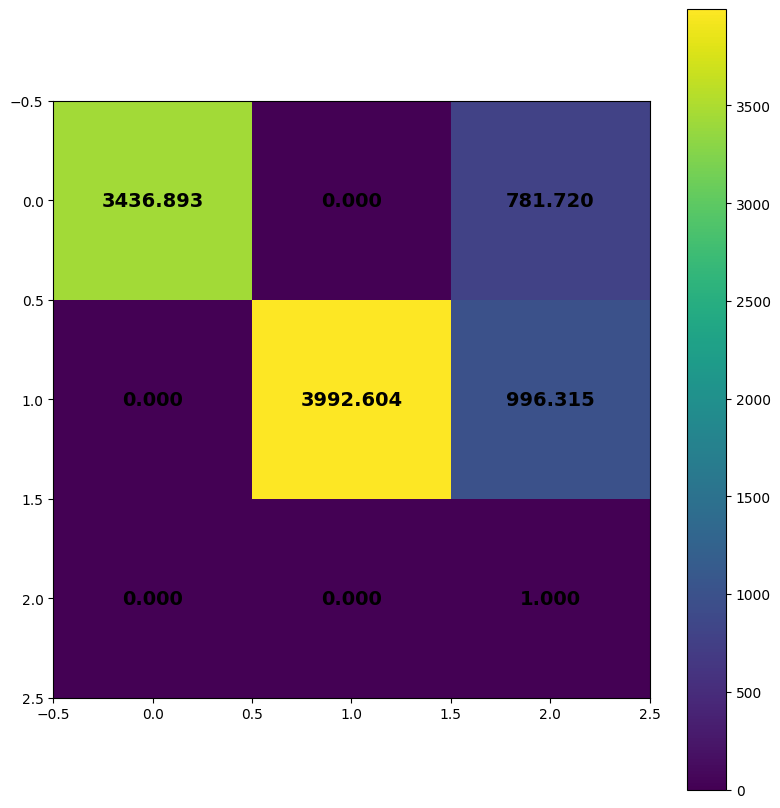

In [5]:
pattern = (7, 7) 
square = 1

coords = []  
imgcoords = [] 

grid = np.zeros((pattern[0] * pattern[1], 3), np.float32)
grid[:, :2] = np.mgrid[0:pattern[0], 0:pattern[1]].T.reshape(-1, 2) * square

paths = []
for i in range(1, 21):
    paths.append(f"../imagenes/imagenes c/{i}.JPEG")

for image in paths:
    img = cv2.imread(image)

    if img is None:
        filename = os.path.basename(image)
        print(f"No se pudo cargar la imagen {filename}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, pattern, None)

    if ret:
        coords.append(grid)
        imgcoords.append(corners)
        
        cv2.drawChessboardCorners(img, pattern, corners, ret)
        
        imgrgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(imgrgb)
        filename = os.path.basename(image)
        plt.title(f'Esquinas de la imagen {filename}')
        plt.axis('off')
        plt.show()

    else:
        filename = os.path.basename(image)
        print(f"No se detectaron esquinas en la imagen {filename}")

if len(coords) > 0:
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(coords, imgcoords, gray.shape[::-1], None, None)
    matrix = K

else:
    matrix = {"No hay suficientes puntos."}

print(K)

visualizar_matriz(K)

### Matriz fundamental usando RANSAC

[[ 1.65467423e-06 -6.76982661e-04  5.68850903e-01]
 [ 6.75222536e-04 -3.95481771e-06 -4.46973364e-01]
 [-5.73151151e-01  4.52821214e-01  1.00000000e+00]]


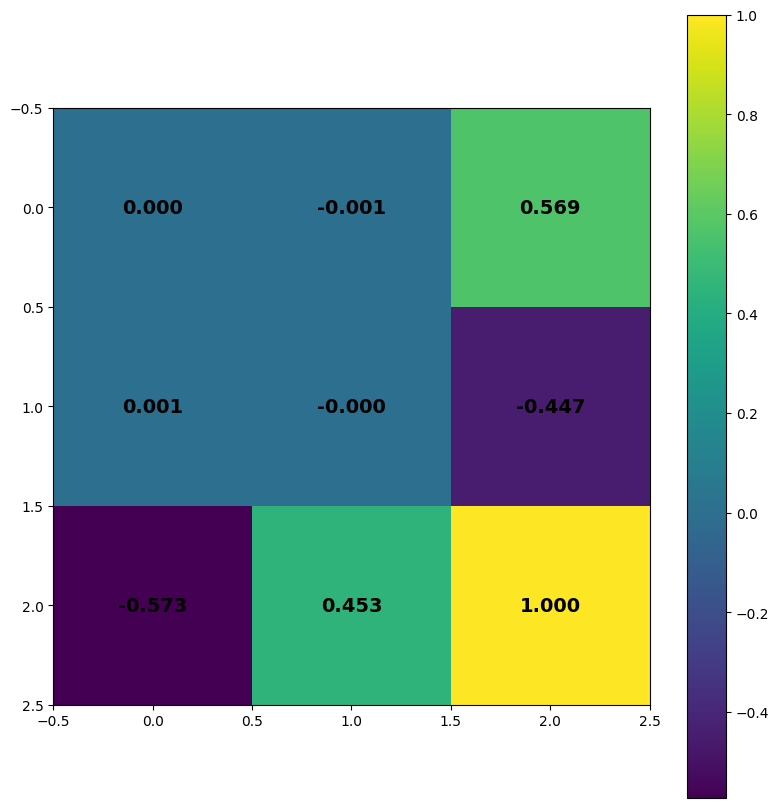

In [6]:
bw_paths = []
directorio = "../imagenes/imagenes bw/"
for filename in os.listdir(directorio):
    if filename.endswith('.JPEG'):
        bw_paths.append(os.path.join(directorio, filename))

# Seleccionar dos imágenes para calcular la matriz fundamental
img1 = cv2.imread(bw_paths[0])
img2 = cv2.imread(bw_paths[1])

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Detectar puntos clave usando SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# Emparejar características usando FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Aplicar test de ratio de Lowe para filtrar buenos matches
good_matches = []
pts1 = []
pts2 = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

print(F)

visualizar_matriz(F)

### Matriz esencial, rotación y traslación

Matriz Esencial:
[[ 1.95454013e+01 -9.28966078e+03 -3.58617233e+02]
 [ 9.26550808e+03 -6.30433094e+01  3.07116396e+02]
 [ 3.46701857e+02 -3.20725433e+02 -8.20719101e-01]]


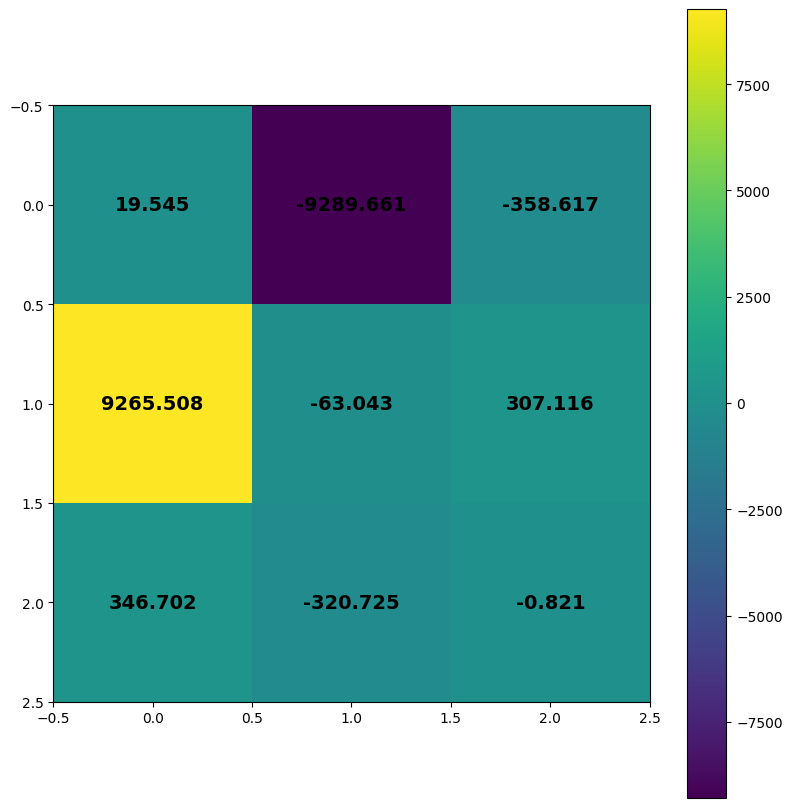


Matriz de Rotación:
[[ 9.99996892e-01 -2.30412476e-03 -9.52140341e-04]
 [ 2.30546037e-03  9.99996357e-01  1.40404053e-03]
 [ 9.48901787e-04 -1.40623129e-03  9.99998561e-01]]


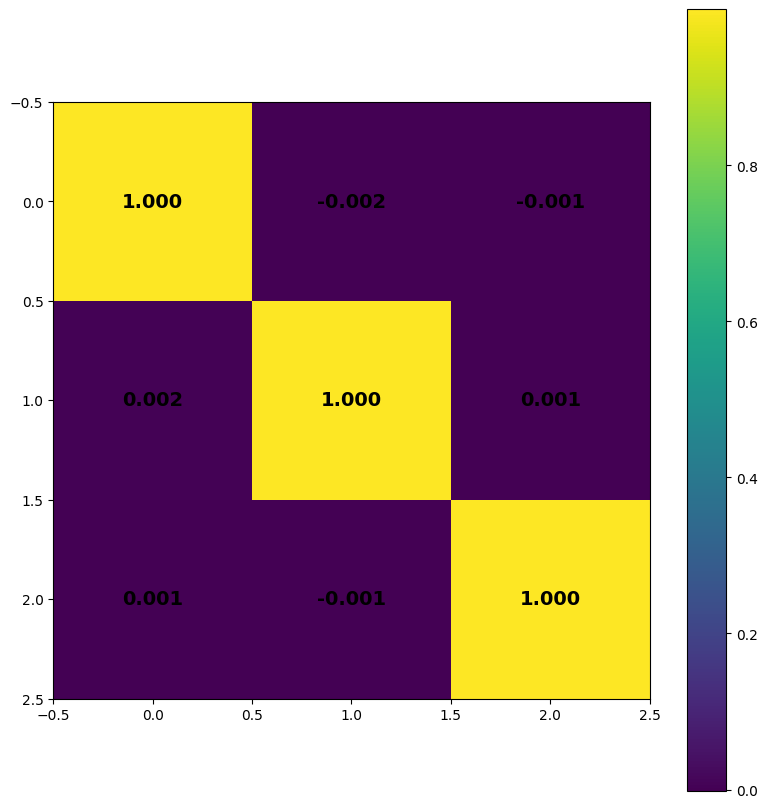


Vector de Traslación:
[[ 0.0342276 ]
 [ 0.03729837]
 [-0.99871783]]


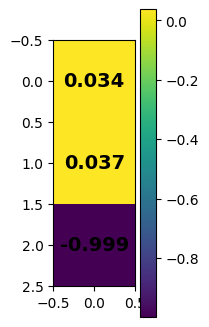

In [7]:
# Calcular la matriz esencial usando la matriz fundamental y la matriz de calibración K
E = K.T @ F @ K

print("Matriz Esencial:")
print(E)
visualizar_matriz(E)

# Descomponer la matriz esencial en rotación y traslación
_, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)

print("\nMatriz de Rotación:")
print(R)
visualizar_matriz(R)

print("\nVector de Traslación:")
print(t)
visualizar_matriz(t)


## Paso 4: Detección de Características y Emparejamiento

Total de pares emparejados: 325
Imagen 1.JPEG: 860 puntos clave detectados
Imagen 2.JPEG: 886 puntos clave detectados
Imagen 3.JPEG: 921 puntos clave detectados
Imagen 4.JPEG: 916 puntos clave detectados
Imagen 5.JPEG: 903 puntos clave detectados
Imagen 6.JPEG: 749 puntos clave detectados
Imagen 7.JPEG: 557 puntos clave detectados
Imagen 8.JPEG: 502 puntos clave detectados
Imagen 9.JPEG: 581 puntos clave detectados
Imagen 10.JPEG: 580 puntos clave detectados
Imagen 11.JPEG: 560 puntos clave detectados
Imagen 12.JPEG: 286 puntos clave detectados
Imagen 13.JPEG: 265 puntos clave detectados
Imagen 14.JPEG: 279 puntos clave detectados
Imagen 15.JPEG: 474 puntos clave detectados
Imagen 16.JPEG: 570 puntos clave detectados
Imagen 17.JPEG: 333 puntos clave detectados
Imagen 18.JPEG: 257 puntos clave detectados
Imagen 19.JPEG: 454 puntos clave detectados
Imagen 20.JPEG: 556 puntos clave detectados
Imagen 21.JPEG: 522 puntos clave detectados
Imagen 22.JPEG: 640 puntos clave detectados
Imagen 23

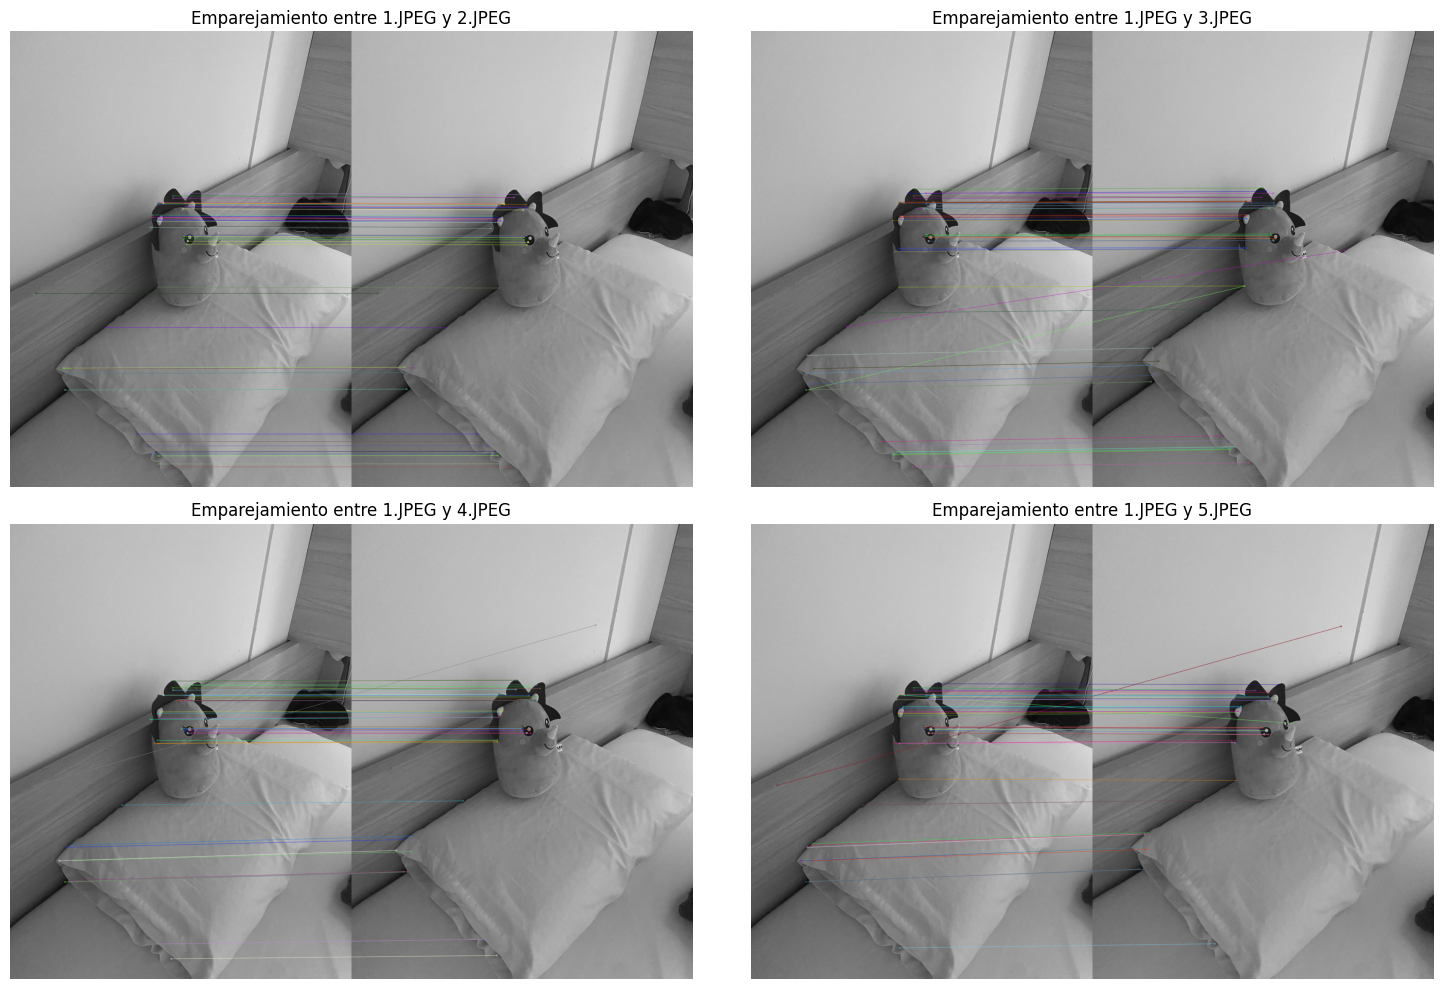

In [8]:
# Crear detector SIFT
sift = cv2.SIFT_create()

# Detectar puntos clave y descriptores en cada imagen
lista_puntos_clave = []
lista_descriptores = []
parametros_imagenes = []

for imagen in imagenes_bw:
    puntos_clave, descriptores = sift.detectAndCompute(imagen, None)
    lista_puntos_clave.append(puntos_clave)
    lista_descriptores.append(descriptores)
    parametros_imagenes.append(len(puntos_clave))

# Emparejar características entre todas las imágenes
INDICE_FLANN_KDTREE = 1
parametros_indice = dict(algorithm=INDICE_FLANN_KDTREE, trees=5)
parametros_busqueda = dict(checks=50)
flann = cv2.FlannBasedMatcher(parametros_indice, parametros_busqueda)

lista_emparejamientos = []
for i in range(len(imagenes_bw)):
    for j in range(i + 1, len(imagenes_bw)):
        emparejamientos = flann.knnMatch(lista_descriptores[i], lista_descriptores[j], k=2)
        
        # Aplicar test de ratio de Lowe
        buenos_emparejamientos = []
        for m, n in emparejamientos:
            if m.distance < 0.7 * n.distance:
                buenos_emparejamientos.append(m)
        
        lista_emparejamientos.append((i, j, buenos_emparejamientos))

# Mostrar número total de pares emparejados
print(f"Total de pares emparejados: {len(lista_emparejamientos)}")

# Mostrar parámetros encontrados en cada imagen
for idx, nombre_archivo in enumerate(archivos_imagenes_bw):
    print(f"Imagen {nombre_archivo}: {parametros_imagenes[idx]} puntos clave detectados")

# Mostrar 4 ejemplos de emparejamientos
num_ejemplos = 4
plt.figure(figsize=(15, 10))
for idx in range(min(num_ejemplos, len(lista_emparejamientos))):
    i, j, buenos_emparejamientos = lista_emparejamientos[idx]
    imagen_emparejada = cv2.drawMatches(imagenes_bw[i], lista_puntos_clave[i],
                                        imagenes_bw[j], lista_puntos_clave[j],
                                        buenos_emparejamientos[:50], None,
                                        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    plt.subplot(2, 2, idx + 1)
    plt.imshow(imagen_emparejada, cmap='gray')
    plt.title(f'Emparejamiento entre {archivos_imagenes_bw[i]} y {archivos_imagenes_bw[j]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Paso 5: Reconstrucción 3D

### La reconstrucción 3D se realizó mediante la interfaz gráfica de colmap, se le proporcionan las imágenes postprocesadas y se utilizó un mesh poisson, y colmap regresa un archivo .ply.

## Paso 6: Visualización del Modelo 3D

In [9]:
archivo_ply = "fused.ply"
nube_puntos = o3d.io.read_point_cloud(archivo_ply)

print(nube_puntos)

o3d.visualization.draw_geometries([nube_puntos], window_name="Visualización de Nube de Puntos",
                                  width=800, height=600, left=50, top=50,
                                  point_show_normal=False)

PointCloud with 254703 points.
